# Goal

* Simulating a fullCyc control gradient
  * Not simulating incorporation (all 0% isotope incorp.)
    * Don't know how much true incorporatation for emperical data
* Using parameters inferred from TRIMMED emperical data (fullCyc seq data), or if not available, default SIPSim parameters
* Determining whether simulated taxa show similar distribution to the emperical  data

## Input parameters
  * phyloseq.bulk file 
  * taxon mapping file
  * list of genomes
  * fragments simulated for all genomes
  * bulk community richness


## workflow

* Creating a community file from OTU abundances in bulk soil samples
  * phyloseq.bulk --> OTU table --> filter to sample --> community table format
* Fragment simulation
  * simulated_fragments --> parse out fragments for target OTUs 
  * simulated_fragments --> parse out fragments from random genomes to obtain richness of interest
  * combine fragment python objects
* Convert fragment lists to kde object
* Add diffusion
* Make incorp config file
* Add isotope incorporation
* Calculating BD shift from isotope incorp
* Simulating gradient fractions
* Simulating OTU table
* Simulating PCR
* Subsampling from the OTU table

## Init

In [32]:
import os
import glob
import re
import nestly

In [33]:
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The pushnote extension is already loaded. To reload it, use:
  %reload_ext pushnote


In [34]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

### BD min/max

In [35]:
%%R
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

cat('Min BD:', min_BD, '\n')
cat('Max BD:', max_BD, '\n')

Min BD: 1.67323 
Max BD: 1.7744 


# Nestly

* assuming fragments already simulated

In [53]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/'
buildDir = os.path.join(workDir, 'rep3_DBL-comm')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags_parsed.pkl'
commFile = '/home/nick/notebook/SIPSim/dev/fullCyc//fullCyc_12C-Con_trm_comm.txt'

nreps = 3

In [54]:
# building tree structure
nest = nestly.Nest()

# varying params
nest.add('rep', [x + 1 for x in xrange(nreps)])


## set params
nest.add('abs', ['1e9'], create_dir=False)
nest.add('percIncorp', [0], create_dir=False)
nest.add('percTaxa', [0], create_dir=False)
nest.add('np', [6], create_dir=False)
nest.add('subsample_dist', ['lognormal'], create_dir=False)
nest.add('subsample_mean', [9.432], create_dir=False)
nest.add('subsample_scale', [0.5], create_dir=False)
nest.add('subsample_min', [10000], create_dir=False)
nest.add('subsample_max', [30000], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('commFile', [commFile], create_dir=False)
nest.add('bandwidth', [0.6], create_dir=False)

# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [55]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

echo '#-- SIPSim pipeline --#'


echo '# converting fragments to KDE'
SIPSim fragment_KDE \
    {fragFile} \
    > ampFrags_KDE.pkl

echo '# adding diffusion'    
SIPSim diffusion \
    ampFrags_KDE.pkl \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif.pkl    

echo '# adding DBL contamination; abundance-weighted smearing'
SIPSim DBL \
    ampFrags_KDE_dif.pkl \
    --comm {commFile} \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif_DBL.pkl
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    ampFrags_KDE_dif_DBL.pkl \
    {percTaxa}_{percIncorp}.config \
    --comm {commFile} \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc.pkl

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    {commFile} \
    > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    ampFrags_KDE_dif_DBL_inc.pkl \
    {commFile} \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
#-- w/ PCR simulation --#
echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
    

#-- w/out PCR simulation --#    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_meta.txt    

Writing /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/SIPSimRun.sh


In [ ]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d rep3_DBL-comm --log-file log.txt -j 3

2016-02-18 19:56:17,223 * INFO * Template: ./SIPSimRun.sh
2016-02-18 19:56:17,225 * INFO * [219741] Started ./SIPSimRun.sh in rep3_DBL-comm/3
2016-02-18 19:56:17,227 * INFO * [219742] Started ./SIPSimRun.sh in rep3_DBL-comm/2
2016-02-18 19:56:17,229 * INFO * [219744] Started ./SIPSimRun.sh in rep3_DBL-comm/1


# BD min/max

* what is the min/max BD that we care about?

In [58]:
%%R
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

cat('Min BD:', min_BD, '\n')
cat('Max BD:', max_BD, '\n')

Min BD: 1.67323 
Max BD: 1.7744 


# Loading non-PCR subsampled OTU tables

In [59]:
OTU_files = !find $buildDir -name "OTU_abs1e9_sub.txt"
OTU_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/3/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/2/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/1/OTU_abs1e9_sub.txt']

In [60]:
%%R -i OTU_files
# loading files

df.SIM = list()
for (x in OTU_files){
    SIM_rep = gsub('/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/', '', x)
    SIM_rep = gsub('/OTU_abs1e9_sub.txt', '', SIM_rep)
    df.SIM[[SIM_rep]] = read.delim(x, sep='\t') 
    }
df.SIM = do.call('rbind', df.SIM)
df.SIM$SIM_rep = gsub('\\.[0-9]+$', '', rownames(df.SIM))
rownames(df.SIM) = 1:nrow(df.SIM)
df.SIM %>% head(n=3)

  library    fraction                          taxon BD_min BD_mid BD_max count
1       1  -inf-1.660 Acaryochloris_marina_MBIC11017   -Inf  1.659  1.659     0
2       1 1.660-1.664 Acaryochloris_marina_MBIC11017  1.660  1.662  1.664     1
3       1 1.664-1.668 Acaryochloris_marina_MBIC11017  1.664  1.666  1.668     0
     rel_abund SIM_rep
1 0.000000e+00       3
2 7.061648e-05       3
3 0.000000e+00       3


# BD range where an OTU is detected 

* Do the simulated OTU BD distributions span the same BD range of the emperical data?

In [66]:
%%R -i commFile
df.SIM.comm = read.delim(commFile, sep='\t') %>%
    mutate(bulk_abund = rel_abund_perc / 100)
df.SIM.comm %>% head

  library                            taxon_name rel_abund_perc rank bulk_abund
1       1          Paenibacillus_terrae_HPL-003       5.728702    1 0.05728702
2       1     Magnetospirillum_magneticum_AMB-1       4.295700    2 0.04295700
3       1           Kitasatospora_setae_KM-6054       2.965853    3 0.02965853
4       1          Thermocrinis_albus_DSM_14484       2.220702    4 0.02220702
5       1 Desulfotomaculum_nigrificans_CO-1-SRB       2.026430    5 0.02026430
6       1 Pseudoalteromonas_translucida_KMM_520       1.800652    6 0.01800652


In [67]:
%%R

## joining SIP & comm (pre-fractionation)
df.SIM.j = inner_join(df.SIM, df.SIM.comm, c('library' = 'library',
                                             'taxon' = 'taxon_name')) %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD)
    
df.SIM.j %>% head(n=3)

  library    fraction                          taxon BD_min BD_mid BD_max count
1       1 1.674-1.677 Acaryochloris_marina_MBIC11017  1.674  1.675  1.677     1
2       1 1.677-1.683 Acaryochloris_marina_MBIC11017  1.677  1.680  1.683     1
3       1 1.683-1.685 Acaryochloris_marina_MBIC11017  1.683  1.684  1.685     0
     rel_abund SIM_rep rel_abund_perc rank   bulk_abund
1 6.379992e-05       3     0.03462713  573 0.0003462713
2 9.378224e-05       3     0.03462713  573 0.0003462713
3 0.000000e+00       3     0.03462713  573 0.0003462713


In [68]:
%%R
# calculating BD range
df.SIM.j.f = df.SIM.j %>%
    filter(count > 0) %>%
    group_by(SIM_rep) %>%
    mutate(max_BD_range = max(BD_mid) - min(BD_mid)) %>%
    ungroup() %>%
    group_by(SIM_rep, taxon) %>%
    summarize(mean_bulk_abund = mean(bulk_abund),
              min_BD = min(BD_mid),
              max_BD = max(BD_mid),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / first(max_BD_range) * 100) %>%
    ungroup() 
    
df.SIM.j.f %>% head(n=3) %>% as.data.frame

  SIM_rep                                taxon mean_bulk_abund min_BD max_BD
1       1       Acaryochloris_marina_MBIC11017    0.0003462713  1.679  1.772
2       1       Acetobacterium_woodii_DSM_1030    0.0013833962  1.679  1.772
3       1 Acetobacter_pasteurianus_IFO_3283-03    0.0002732119  1.707  1.772
  BD_range BD_range_perc
1    0.093     100.00000
2    0.093     100.00000
3    0.065      69.89247


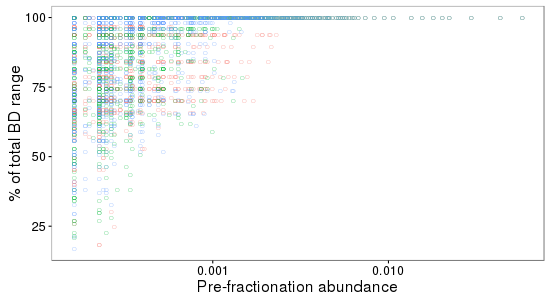

In [69]:
%%R -h 300 -w 550
## plotting
ggplot(df.SIM.j.f, aes(mean_bulk_abund, BD_range_perc, color=SIM_rep)) +
    geom_point(alpha=0.5, shape='O') +
    scale_x_log10() +
    scale_y_continuous() +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    #geom_vline(xintercept=0.001, linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank(),
        legend.position = 'none'
        )

# Assessing diversity

### Asigning zeros

In [70]:
%%R
# giving value to missing abundances
min.pos.val = df.SIM.j %>%
    filter(rel_abund > 0) %>%
    group_by() %>%
    mutate(min_abund = min(rel_abund)) %>%
    ungroup() %>%
    filter(rel_abund == min_abund)

min.pos.val = min.pos.val[1,'rel_abund'] %>% as.numeric
imp.val = min.pos.val / 10


# convert numbers
df.SIM.j[df.SIM.j$rel_abund == 0, 'abundance'] = imp.val

# another closure operation
df.SIM.j = df.SIM.j %>%
    group_by(SIM_rep, fraction) %>%
    mutate(rel_abund = rel_abund / sum(rel_abund))


# status
cat('Below detection level abundances converted to: ', imp.val, '\n')

Below detection level abundances converted to:  3.343363e-06 


## Plotting Shannon diversity for each

In [71]:
%%R
shannon_index_long = function(df, abundance_col, ...){
    # calculating shannon diversity index from a 'long' formated table
    ## community_col = name of column defining communities
    ## abundance_col = name of column defining taxon abundances
    df = df %>% as.data.frame
    cmd = paste0(abundance_col, '/sum(', abundance_col, ')')
    df.s = df %>%
        group_by_(...) %>%
        mutate_(REL_abundance = cmd) %>%
        mutate(pi__ln_pi = REL_abundance * log(REL_abundance),
               shannon = -sum(pi__ln_pi, na.rm=TRUE)) %>%
        ungroup() %>% 
        dplyr::select(-REL_abundance, -pi__ln_pi) %>%
        distinct_(...) 
    return(df.s)
}

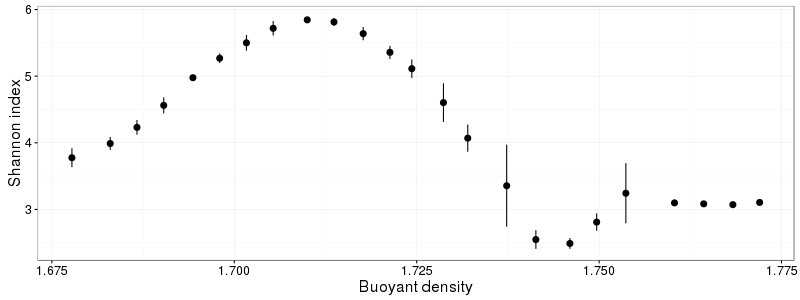

In [72]:
%%R -w 800 -h 300
# calculating shannon
df.SIM.shan = shannon_index_long(df.SIM.j, 'count', 'library', 'fraction') %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD) 

df.SIM.shan.s = df.SIM.shan %>%
    group_by(BD_bin = ntile(BD_mid, 24)) %>%
    summarize(mean_BD = mean(BD_mid),
              mean_shannon = mean(shannon),
              sd_shannon = sd(shannon))

# plotting
p = ggplot(df.SIM.shan.s, aes(mean_BD, mean_shannon, 
                             ymin=mean_shannon-sd_shannon,
                             ymax=mean_shannon+sd_shannon)) +
    geom_pointrange() +
    labs(x='Buoyant density', y='Shannon index') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

# Plotting variance

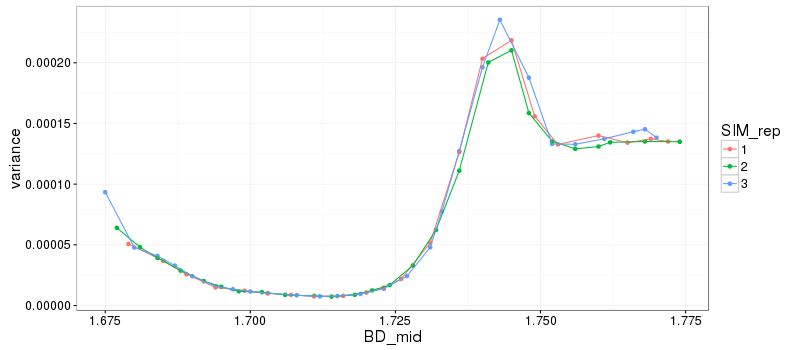

In [73]:
%%R -w 800 -h 350
df.SIM.j.var = df.SIM.j %>%
    group_by(SIM_rep, fraction) %>%
    mutate(variance = var(rel_abund)) %>%
    ungroup() %>%
    distinct(SIM_rep, fraction) %>%
    select(SIM_rep, fraction, variance, BD_mid)

ggplot(df.SIM.j.var, aes(BD_mid, variance, color=SIM_rep)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

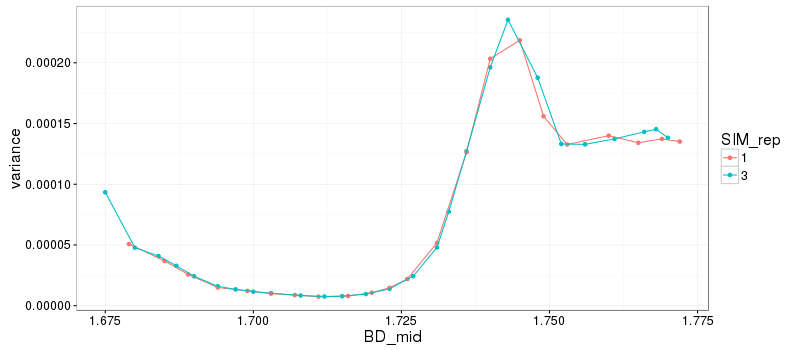

In [74]:
%%R -w 800 -h 350

ggplot(df.SIM.j.var %>% filter(SIM_rep %in% c('1', '3')), aes(BD_mid, variance, color=SIM_rep)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes

* spike at high G+C
  * absence of taxa or presence of taxa at those locations?

# Plotting absolute abundance distributions 

In [75]:
OTU_files = !find $buildDir -name "OTU_abs1e9.txt"
OTU_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/3/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/2/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/1/OTU_abs1e9.txt']

In [76]:
%%R -i OTU_files
# loading files

df.abs = list()
for (x in OTU_files){
    SIM_rep = gsub('/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm/', '', x)
    SIM_rep = gsub('/OTU_abs1e9.txt', '', SIM_rep)
    df.abs[[SIM_rep]] = read.delim(x, sep='\t') 
    }
df.abs = do.call('rbind', df.abs)
df.abs$SIM_rep = gsub('\\.[0-9]+$', '', rownames(df.abs))
rownames(df.abs) = 1:nrow(df.abs)
df.abs %>% head(n=3)

  library                          taxon    fraction BD_min BD_mid BD_max count
1       1 Acaryochloris_marina_MBIC11017  -inf-1.660   -Inf  1.659  1.659    28
2       1 Acaryochloris_marina_MBIC11017 1.660-1.664  1.660  1.662  1.664    10
3       1 Acaryochloris_marina_MBIC11017 1.664-1.668  1.664  1.666  1.668     9
     rel_abund SIM_rep
1 4.976583e-05       3
2 5.001225e-05       3
3 4.110283e-05       3


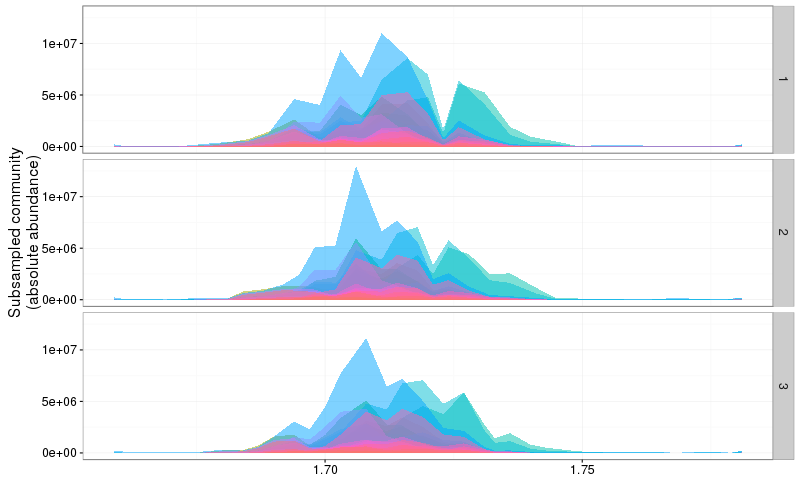

In [77]:
%%R -w 800 

ggplot(df.abs, aes(BD_mid, count, fill=taxon)) +
    geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(SIM_rep ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )

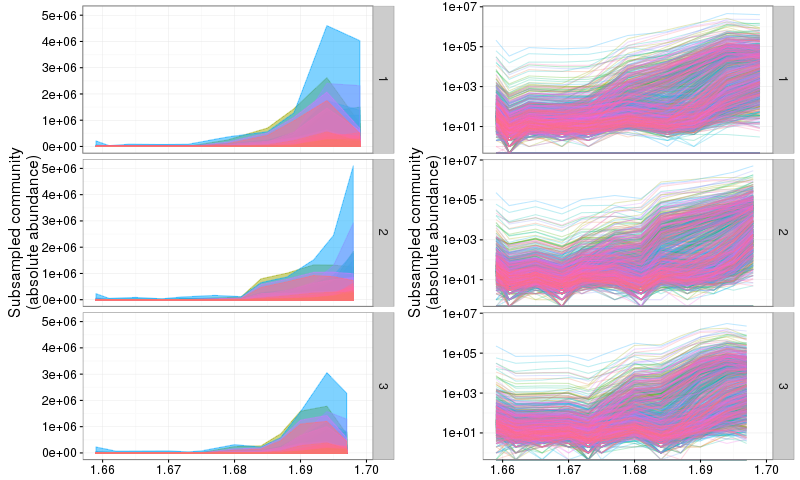

In [78]:
%%R -w 800 

p1 = ggplot(df.abs %>% filter(BD_mid < 1.7), aes(BD_mid, count, fill=taxon, color=taxon)) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(SIM_rep ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )

p2 = p1 + geom_line(alpha=0.25) + scale_y_log10()
p1 = p1 + geom_area(stat='identity', position='dodge', alpha=0.5) 

grid.arrange(p1, p2, ncol=2)

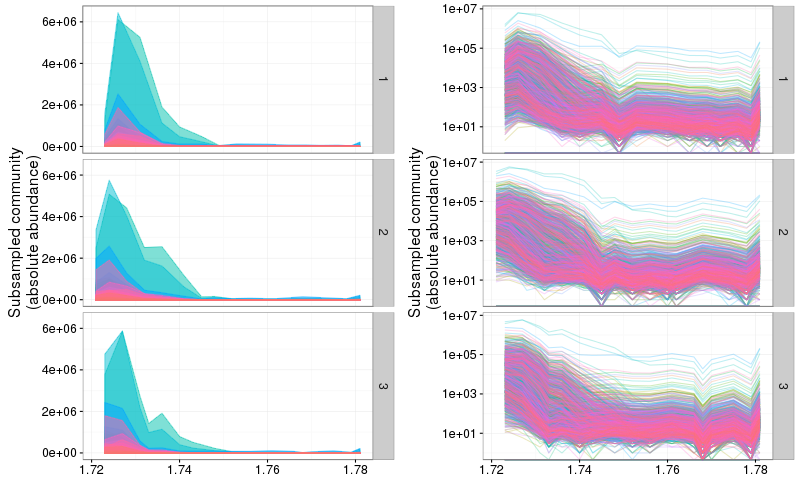

In [79]:
%%R -w 800 

p1 = ggplot(df.abs %>% filter(BD_mid > 1.72), aes(BD_mid, count, fill=taxon, color=taxon)) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(SIM_rep ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )


p2 = p1 + geom_line(alpha=0.25) + scale_y_log10()
p1 = p1 + geom_area(stat='identity', position='dodge', alpha=0.5) 

grid.arrange(p1, p2, ncol=2)

# Conclusions